In [1]:
# -*- coding: utf-8 -*-
from __future__ import division
import sys
sys.path.append('C:\\Users\\51951\\PycharmProjects\\joinquantNew\\gpLearn')
import pandas as pd
import numpy as np
import time  
import datetime
from matplotlib import cm, pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from factors201 import *
import inspect
from jqdatasdk import *
from configDB import *
import os
auth(JOINQUANT_USER, JOINQUANT_PW)
from scipy import stats
import math
import warnings
warnings.filterwarnings("ignore")

提示：当前环境pandas版本为0.25，get_price与get_fundamentals_continuously接口panel参数将固定为False
注意：0.25以上版本pandas不支持panel，如使用该数据结构和相关函数请注意修改
auth success 


In [2]:
colums_lst = ["alpha801", "alpha802", "alpha803", "alpha804", "alpha805"]
colums_lst.extend(['date_time', 'close', 'future_ret'])
feature_lst = ["alpha801", "alpha802", "alpha803", "alpha804", "alpha805"]

## 获取中证800指数(000906)成分股

In [8]:
try:
    index_stocks = pd.read_csv('c:/e/data/stock_hq/index_stocks_000906.csv')
except:
    calen = get_trade_days('2014-01-01', '2020-12-11')
    index_stocks = []
    for date_ in calen:
        tmp = pd.DataFrame(get_index_stocks('000906.XSHG', date=date_), columns=['stock_code'])
        tmp['date_time'] = datetime.datetime.strftime(date_, '%Y-%m-%d')
        index_stocks.append(tmp)
    index_stocks = pd.concat(index_stocks)
    index_stocks.to_csv('c:/e/data/stock_hq/index_stocks_000906.csv', index=False)
index_stocks

,stock_code,date_time
0,000001.XSHE,2014-01-02
1,000002.XSHE,2014-01-02
2,000006.XSHE,2014-01-02
3,000009.XSHE,2014-01-02
4,000012.XSHE,2014-01-02
...,...,...
795,603899.XSHG,2020-12-11
796,603939.XSHG,2020-12-11
797,603983.XSHG,2020-12-11
798,603986.XSHG,2020-12-11


In [29]:
index_stocks = index_stocks.rename(columns={'stock_code': 'symbol'})

In [12]:
sdate = '2014-01-01'
edate = '2020-12-11'
stock_lst = list(set(index_stocks['stock_code'].tolist()))
len(stock_lst)

1280

In [10]:
def stock_price(sec, period, sday, eday):
    """
    输入 股票代码，开始日期，截至日期
    输出 个股的后复权的开高低收价格
    """
    # temp = get_price(sec, start_date=sday, end_date=eday, frequency=period,
    #                  skip_paused=True, fq='pre', count=None).reset_index() \
    #     .rename(columns={'index': 'trade_date'})\
    #     .assign(trade_date=lambda df: df.trade_date.apply(lambda x: str(x)[:16]))[
    #     ['trade_date', 'open', 'high', 'low', 'close', 'volume']].dropna().set_index(['trade_date'])
    temp = get_price(sec, start_date=sday, end_date=eday, frequency=period,
                     skip_paused=True, fq='pre', count=None).reset_index()\
        .rename(columns={'index': 'date_time'})\
        .assign(date_time=lambda df: df.date_time.apply(lambda x: str(x)[:16]))
    temp = temp[
        ['date_time', 'open', 'high', 'low', 'close', 'volume', 'money']].dropna()
    # temp['stock_code'] = sec
    return temp


def get_stock_hq(sec, sdate, edate):
    try:
        df = pd.read_csv('c:/e/data/stock_hq/%s_daily.csv' % sec, encoding='gbk')
        df['date_time'] = df['date_time'].apply(lambda x: str(x)[:10])
        df = df[(df['date_time'] >= sdate) & (df['date_time'] <= edate)]
        df = df.reset_index(drop=True)
    except:
        df = stock_price(sec, 'daily', sdate, edate)
        df.to_csv('c:/e/data/stock_hq/%s_daily.csv' % sec, encoding='gbk')
        df['date_time'] = df['date_time'].apply(lambda x: str(x)[:10])
        df = df[(df['date_time'] >= sdate) & (df['date_time'] <= edate)]
        df = df.reset_index(drop=True)
    return df

In [13]:
resualt_path = 'c:/e/data/factor/stock/'
future_period = 1
indicator_ori = []
for code in stock_lst:
    try:
        ret = pd.read_csv(resualt_path + 'indicator_%s%s.csv' % (code[:6], future_period), encoding='gbk', index_col=0)[colums_lst]
    except:
        print(code)
        hq = get_stock_hq(code, sdate, edate)
        Alpha = Alphas(hq)
        ret = hq[['date_time', 'close']]
        ret['future_ret'] = ret['close'].shift(-future_period) / ret['close']
        for feature in feature_lst:
            ret[feature] = eval('Alpha.' + feature)()
        ret['symbol'] = code
        ret.to_csv(resualt_path + 'indicator_%s%s.csv' % (code[:6], future_period), encoding='gbk')
    indicator_ori.append(ret)
indicator_ori = pd.concat(indicator_ori)

000538.XSHE
002008.XSHE
002807.XSHE
000629.XSHE
600765.XSHG
002430.XSHE
300024.XSHE
601860.XSHG
601238.XSHG
601515.XSHG
601001.XSHG
002489.XSHE
300324.XSHE
002063.XSHE
002407.XSHE
600750.XSHG
600503.XSHG
002056.XSHE
300001.XSHE
000401.XSHE
600597.XSHG
000816.XSHE
002431.XSHE
000562.XSHE
600606.XSHG
600036.XSHG
600637.XSHG
300450.XSHE
000402.XSHE
603939.XSHG
600797.XSHG
002281.XSHE
600869.XSHG
600582.XSHG
600583.XSHG
002236.XSHE
300147.XSHE
002233.XSHE
600422.XSHG
002657.XSHE
600198.XSHG
000090.XSHE
002280.XSHE
000935.XSHE
000708.XSHE
002572.XSHE
601390.XSHG
000600.XSHE
600518.XSHG
600885.XSHG
600612.XSHG
000555.XSHE
600019.XSHG
002244.XSHE
603233.XSHG
600959.XSHG
300315.XSHE
002204.XSHE
601099.XSHG
603899.XSHG
601006.XSHG
600895.XSHG
002444.XSHE
600909.XSHG
600308.XSHG
000587.XSHE
002181.XSHE
002411.XSHE
002936.XSHE
000608.XSHE
600038.XSHG
000513.XSHE
600795.XSHG
600581.XSHG
600888.XSHG
002570.XSHE
603699.XSHG
000488.XSHE
600690.XSHG
002194.XSHE
601319.XSHG
600277.XSHG
000547.XSHE
6000

000917.XSHE
002332.XSHE
601598.XSHG
600401.XSHG
600315.XSHG
600460.XSHG
600773.XSHG
002309.XSHE
600757.XSHG
600491.XSHG
600061.XSHG
002727.XSHE
600121.XSHG
000627.XSHE
000850.XSHE
000861.XSHE
002946.XSHE
600018.XSHG
600601.XSHG
600996.XSHG
002190.XSHE
600056.XSHG
000518.XSHE
000541.XSHE
601997.XSHG
603338.XSHG
000582.XSHE
000157.XSHE
000667.XSHE
601991.XSHG
600687.XSHG
600100.XSHG
600479.XSHG
002183.XSHE
601886.XSHG
600483.XSHG
002203.XSHE
600050.XSHG
300630.XSHE
002440.XSHE
300026.XSHE
300142.XSHE
600588.XSHG
000158.XSHE
603816.XSHG
002424.XSHE
600939.XSHG
000725.XSHE
600551.XSHG
000540.XSHE
600155.XSHG
002081.XSHE
600683.XSHG
000581.XSHE
601388.XSHG
600600.XSHG
601009.XSHG
001979.XSHE
601326.XSHG
000625.XSHE
000981.XSHE
002503.XSHE
601398.XSHG
600467.XSHG
601377.XSHG
601186.XSHG
002583.XSHE
603650.XSHG
603556.XSHG
002470.XSHE
000536.XSHE
601678.XSHG
002480.XSHE
002477.XSHE
601126.XSHG
002249.XSHE
000979.XSHE
000895.XSHE
601225.XSHG
000762.XSHE
300253.XSHE
600273.XSHG
600418.XSHG
6001

In [61]:
indicator_ori['future_ret'] = indicator_ori['future_ret']-1
indicator_ori

,date_time,close,future_ret,alpha801,alpha802,alpha803,alpha804,alpha805,symbol
151,2014-08-14,48.15,0.007269,-0.078476,0.475536,0.164274,-0.963691,-0.078160,000538.XSHE
152,2014-08-15,48.50,0.005773,0.096207,0.463672,0.177423,-0.960802,-0.113229,000538.XSHE
153,2014-08-18,48.78,-0.001640,0.400929,0.514572,0.220174,-0.950705,-0.163280,000538.XSHE
154,2014-08-19,48.70,-0.015606,0.440788,0.521788,0.245833,-0.936033,-0.218802,000538.XSHE
155,2014-08-20,47.94,0.003338,-0.082813,0.319468,0.175266,-0.935297,-0.244319,000538.XSHE
...,...,...,...,...,...,...,...,...,...
1669,2020-11-10,5.08,0.021654,-0.209761,-0.813816,-0.861304,-0.248256,0.026493,600123.XSHG
1670,2020-11-11,5.19,-0.009634,0.482620,-0.389037,-0.691354,-0.149383,0.071062,600123.XSHG
1671,2020-11-12,5.14,-0.005837,0.493409,-0.183870,-0.588456,-0.111183,0.088752,600123.XSHG
1672,2020-11-13,5.11,0.035225,0.278432,-0.167956,-0.554741,-0.109828,0.090018,600123.XSHG


In [62]:
len(indicator_ori), len(indicator_ori.dropna())

(1700309, 1700309)

In [63]:
indicator_df_day = indicator_ori[indicator_ori['date_time'] == '2020-10-20'].drop(['date_time', 'close', 'future_ret'], axis=1)\
.set_index(['symbol'])

In [64]:
indicator_df_day

,alpha801,alpha802,alpha803,alpha804,alpha805
symbol,,,,,
000538.XSHE,-0.348834,-0.263959,0.192981,0.893449,0.002116
002008.XSHE,0.457404,0.164392,-0.776838,-0.433472,0.875573
002807.XSHE,0.019327,-0.017693,-0.485615,0.461078,0.701177
000629.XSHE,-0.958727,-0.924882,-0.957138,-0.605120,-0.945545
600765.XSHG,-0.367464,0.876440,0.915374,0.276721,0.000761
...,...,...,...,...,...
002371.XSHE,0.190953,0.397198,-0.328615,0.090865,0.511481
600322.XSHG,-0.845165,-0.937721,-0.888286,-0.021153,0.615493
002212.XSHE,-0.181539,0.674496,0.757184,0.316467,0.910116


## 去极值

In [65]:
def de_extreme(indicator_df_day, feature_lst):
    indicator_df_day_temp = copy.deepcopy(indicator_df_day)
    MAD = abs(indicator_df_day_temp - indicator_df_day_temp.median())
    MAX=indicator_df_day_temp.median() + 3 * 1.4826 * MAD.median()
    MIN=indicator_df_day_temp.median() - 3 * 1.4826 * MAD.median()
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series[series>MAX[alpha]] = MAX[alpha]
        series[series<MIN[alpha]] = MIN[alpha]
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
        df = pd.DataFrame({'ori': ori, 'de_extreme': indicator_df_day_temp[alpha]})\
        .reset_index(drop=True)
#         plt.subplots(20, 10)
        df.loc[:, ['ori', 'de_extreme']].plot()
        plt.legend()
        plt.title('%s ori_max:%s deal_max:%s ori_min:%s deal_min:%s' %(
            alpha, np.around(ori.max(), 2), np.around(series.max(), 2), np.around(ori.min(), 2), 
                  np.around(series.min(), 2)))
        plt.show()
    return(indicator_df_day_temp)

def de_extreme_noplot(indicator_df_day, feature_lst):
    indicator_df_day_temp = copy.deepcopy(indicator_df_day)
    MAD = abs(indicator_df_day_temp - indicator_df_day_temp.median())
    MAX=indicator_df_day_temp.median() + 3 * 1.4826 * MAD.median()
    MIN=indicator_df_day_temp.median() - 3 * 1.4826 * MAD.median()
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series[series>MAX[alpha]] = MAX[alpha]
        series[series<MIN[alpha]] = MIN[alpha]
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
    return(indicator_df_day_temp)

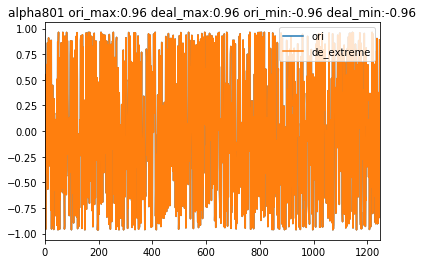

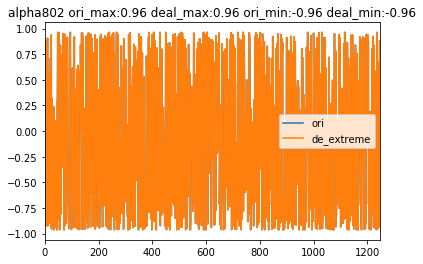

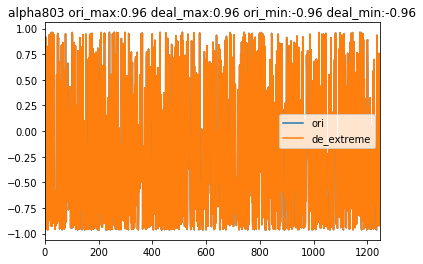

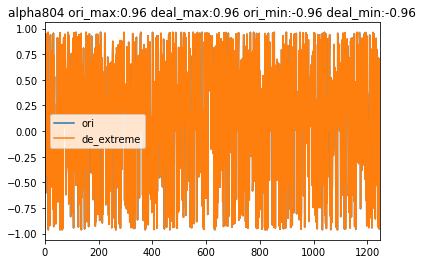

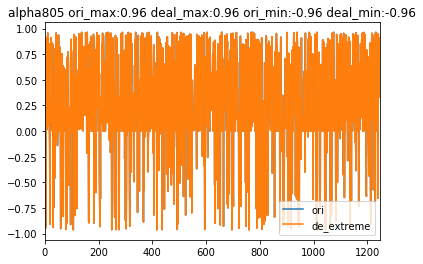

In [66]:
indicator_df_day_temp = de_extreme(indicator_df_day, feature_lst)

## 因子标准化

In [67]:
# 标准化函数：
def standardize(s, ty=1):
    '''
    s为Series数据
    ty为标准化类型:1 MinMax,2 Standard,3 maxabs
    '''
    data = s.dropna().copy()
    if int(ty) == 1:
        re = (data - data.min()) / (data.max() - data.min())
    elif ty == 2:
        re = (data - data.mean()) / data.std()
    elif ty == 3:
        re = data / 10 ** np.ceil(np.log10(data.abs().max()))
    return re

def standardize_df_noplot(indicator_df_day, ty=1):
    indicator_df_day_temp = copy.deepcopy(indicator_df_day)
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series = standardize(series, ty)
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
    return(indicator_df_day_temp)

def standardize_df(indicator_df_day, ty=1):
    indicator_df_day_temp = copy.deepcopy(indicator_df_day)
    for alpha in feature_lst:
        ori = copy.deepcopy(indicator_df_day_temp[alpha])
        series = copy.deepcopy(ori)
        series = standardize(series, ty)
        indicator_df_day_temp[alpha] = copy.deepcopy(series)
        df = pd.DataFrame({'ori': ori, 'std': indicator_df_day_temp[alpha]})\
        .reset_index(drop=True)
#         plt.subplots(20, 10)
        df.loc[:, ['ori', 'std']].plot()
        plt.legend()
        plt.title('%s ori_max:%s deal_max:%s ori_min:%s deal_min:%s' %(
            alpha, np.around(ori.max(), 2), np.around(series.max(), 2), np.around(ori.min(), 2), 
                  np.around(series.min(), 2)))
        plt.show()
    return(indicator_df_day_temp)

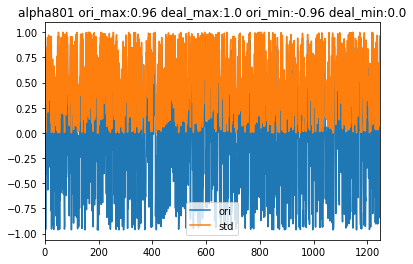

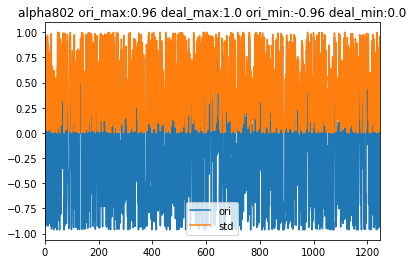

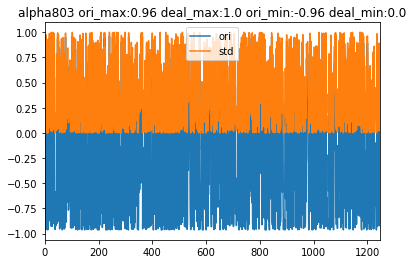

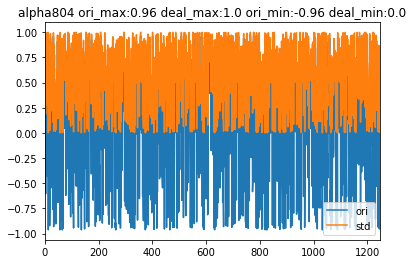

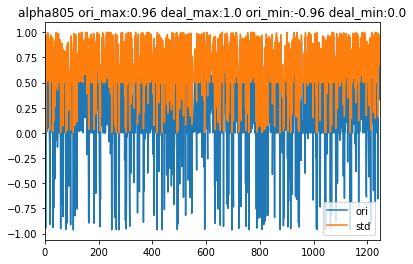

In [22]:
indicator_df_day_std = standardize_df(indicator_df_day_temp)

In [23]:
calen = get_trade_days('2014-01-01', '2020-12-14')

In [24]:
factor_deal=indicator_df_day_std
factor_deal

,alpha801,alpha802,alpha803,alpha804,alpha805
symbol,,,,,
000538.XSHE,0.319028,0.363063,0.600121,0.963513,0.501093
002008.XSHE,0.737298,0.585290,0.096984,0.275118,0.954239
002807.XSHE,0.510027,0.490825,0.248069,0.739203,0.863764
000629.XSHE,0.002620,0.020179,0.003445,0.186069,0.009450
600765.XSHG,0.309363,0.954696,0.974895,0.643560,0.500390
...,...,...,...,...,...
002371.XSHE,0.599065,0.706068,0.329520,0.547140,0.765350
600322.XSHG,0.061535,0.013518,0.039165,0.489026,0.819311
002212.XSHE,0.405819,0.849929,0.892827,0.664180,0.972160


## 标准化处理后因子相关系数

In [25]:
factor_deal.corr()

,alpha801,alpha802,alpha803,alpha804,alpha805
alpha801,1.000000,0.809991,0.459223,0.172655,-0.055231
alpha802,0.809991,1.000000,0.761538,0.355116,-0.057941
alpha803,0.459223,0.761538,1.000000,0.588425,-0.097684
alpha804,0.172655,0.355116,0.588425,1.000000,0.151652
alpha805,-0.055231,-0.057941,-0.097684,0.151652,1.000000


## 对所有日期进行因子处理

In [26]:
indicator_ori = indicator_ori.dropna()
indicator_df_ = indicator_ori.drop(['close', 'future_ret'], axis=1)
indicator_df_

,date_time,alpha801,alpha802,alpha803,alpha804,alpha805,symbol
151,2014-08-14,-0.078476,0.475536,0.164274,-0.963691,-0.078160,000538.XSHE
152,2014-08-15,0.096207,0.463672,0.177423,-0.960802,-0.113229,000538.XSHE
153,2014-08-18,0.400929,0.514572,0.220174,-0.950705,-0.163280,000538.XSHE
154,2014-08-19,0.440788,0.521788,0.245833,-0.936033,-0.218802,000538.XSHE
155,2014-08-20,-0.082813,0.319468,0.175266,-0.935297,-0.244319,000538.XSHE
...,...,...,...,...,...,...,...
1669,2020-11-10,-0.209761,-0.813816,-0.861304,-0.248256,0.026493,600123.XSHG
1670,2020-11-11,0.482620,-0.389037,-0.691354,-0.149383,0.071062,600123.XSHG
1671,2020-11-12,0.493409,-0.183870,-0.588456,-0.111183,0.088752,600123.XSHG
1672,2020-11-13,0.278432,-0.167956,-0.554741,-0.109828,0.090018,600123.XSHG


In [69]:
try:
    indicator_deal = pd.read_csv('c:/e/data/factor/inicator_stock%s.csv' %future_period)
except:
    indicator_deal = []
    for date, group in indicator_df_.groupby(['date_time']):
        if date<'2015-01-01':
            continue
        
        try:
            indicator_deal.append(pd.read_csv('c:/e/data/factor/date_stock/inicator_%s%s.csv' %(date, future_period)))
        except:
            print(date)
            group = group.drop(['date_time'], axis=1)
            group = group.set_index(['symbol'])
            indicator_df_day_de_extreme = de_extreme_noplot(group, feature_lst) # 去极值
            factor_deal = standardize_df_noplot(indicator_df_day_de_extreme) # 标准化
            factor_deal = factor_deal.reset_index(drop=False)
            factor_deal['date_time'] = date
            factor_deal.to_csv('c:/e/data/factor/date_stock/inicator_%s%s.csv' %(date, future_period), index=False)
            indicator_deal.append(factor_deal)
    indicator_deal = pd.concat(indicator_deal) 
    print(indicator_deal)
    indicator_deal.to_csv('c:/e/data/factor/inicator_stock%s.csv' %future_period, index=False)

In [70]:
indicator_deal

,symbol,alpha801,alpha802,alpha803,alpha804,alpha805,date_time
0,000538.XSHE,0.842829,0.930266,0.743418,0.806182,1.000000,2015-01-05
1,002008.XSHE,0.001941,0.056096,0.117373,0.000000,0.000000,2015-01-05
2,000629.XSHE,0.971774,0.818325,0.500552,0.484833,0.442568,2015-01-05
3,600765.XSHG,0.005920,0.015304,0.059716,1.000000,0.536541,2015-01-05
4,002430.XSHE,0.341289,0.689761,0.747478,0.484973,0.442567,2015-01-05
...,...,...,...,...,...,...,...
1612975,002371.XSHE,0.803646,0.993446,0.985909,0.953817,0.728128,2020-11-16
1612976,600322.XSHG,0.624351,0.052885,0.043548,0.000179,0.103894,2020-11-16
1612977,002212.XSHE,0.042286,0.062932,0.061044,0.030062,0.266340,2020-11-16
1612978,002261.XSHE,0.229048,0.030680,0.284531,0.202369,0.055716,2020-11-16


In [71]:
indicator_deal = indicator_deal.merge(index_stocks, on=['date_time', 'symbol'])

In [72]:
indicator_deal

,symbol,alpha801,alpha802,alpha803,alpha804,alpha805,date_time
0,000538.XSHE,0.842829,0.930266,0.743418,0.806182,1.000000,2015-01-05
1,002008.XSHE,0.001941,0.056096,0.117373,0.000000,0.000000,2015-01-05
2,000629.XSHE,0.971774,0.818325,0.500552,0.484833,0.442568,2015-01-05
3,600765.XSHG,0.005920,0.015304,0.059716,1.000000,0.536541,2015-01-05
4,002430.XSHE,0.341289,0.689761,0.747478,0.484973,0.442567,2015-01-05
...,...,...,...,...,...,...,...
1090589,601016.XSHG,0.310111,0.144768,0.206021,0.946314,0.519362,2020-11-16
1090590,600392.XSHG,0.950128,0.999977,0.535809,0.043882,0.030307,2020-11-16
1090591,600406.XSHG,0.893248,0.926315,0.963026,0.952833,0.658809,2020-11-16
1090592,002371.XSHE,0.803646,0.993446,0.985909,0.953817,0.728128,2020-11-16


## 单因子检验 ICIR

In [73]:
# 计算IC值
def IC_cal(df, feature_lst):
    num = 0
    for i in feature_lst:
        t = df.loc[:, ['date_time', 'future_ret', i]].dropna()
        tmp = t.groupby('date_time').apply(lambda df: df.corr().iloc[0, 1]) \
            .reset_index().rename(columns={0: i})
        if num == 0:
            ret = tmp
        else:
            ret = pd.merge(ret, tmp, on=['date_time'], how='outer')
        num += 1
    return ret

# 计算rank_IC值
def rankIC_cal(df, feature_lst):
    num = 0
    for i in feature_lst:
        t = df.loc[:, ['date_time', 'future_ret', i]].dropna()
        t[i] = t[i].rank(ascending=True)
        tmp = t.groupby('date_time').apply(lambda df: df.corr().iloc[0, 1]) \
            .reset_index().rename(columns={0: i})
        if num == 0:
            ret = tmp
        else:
            ret = pd.merge(ret, tmp, on=['date_time'], how='outer')
        num += 1
    return ret

# 计算IR值
def IR_cal(df):
    IR = df.set_index('date_time').apply(lambda s: np.mean(s) / np.std(s))
    return IR

def IC_mean(df):
    return abs(df.mean())


def over_ratio(df, num):
    tmp = copy.deepcopy(df)
    tmp[tmp > num] = 1
    tmp[tmp <= num] = 0
    tmp = tmp.sum() / len(tmp)
    return tmp

In [74]:
indicator_df = indicator_deal.merge(indicator_ori[['date_time', 'symbol', 'future_ret']], on=['date_time', 'symbol'])

In [75]:
indicator_df

,symbol,alpha801,alpha802,alpha803,alpha804,alpha805,date_time,future_ret
0,000538.XSHE,0.842829,0.930266,0.743418,0.806182,1.000000,2015-01-05,0.035040
1,002008.XSHE,0.001941,0.056096,0.117373,0.000000,0.000000,2015-01-05,0.018018
2,000629.XSHE,0.971774,0.818325,0.500552,0.484833,0.442568,2015-01-05,-0.010638
3,600765.XSHG,0.005920,0.015304,0.059716,1.000000,0.536541,2015-01-05,0.064997
4,002430.XSHE,0.341289,0.689761,0.747478,0.484973,0.442567,2015-01-05,0.012746
...,...,...,...,...,...,...,...,...
1090589,601016.XSHG,0.310111,0.144768,0.206021,0.946314,0.519362,2020-11-16,-0.021429
1090590,600392.XSHG,0.950128,0.999977,0.535809,0.043882,0.030307,2020-11-16,0.002564
1090591,600406.XSHG,0.893248,0.926315,0.963026,0.952833,0.658809,2020-11-16,0.003353
1090592,002371.XSHE,0.803646,0.993446,0.985909,0.953817,0.728128,2020-11-16,0.021851


In [35]:
del(indicator_deal)

In [76]:
# 计算 IC ，IR值
IC = IC_cal(indicator_df, feature_lst)
IR = IR_cal(IC)
IC

,date_time,alpha801,alpha802,alpha803,alpha804,alpha805
0,2015-01-05,-0.396905,-0.322435,-0.109930,-0.009274,-0.146897
1,2015-01-06,0.019716,0.096809,-0.006669,-0.053531,0.002593
2,2015-01-07,-0.237480,-0.283468,-0.097322,0.015237,-0.103290
3,2015-01-08,-0.201787,-0.163161,-0.147713,-0.065915,0.001172
4,2015-01-09,0.193263,-0.041840,-0.004269,-0.008013,0.022038
...,...,...,...,...,...,...
1424,2020-11-10,0.030583,-0.057084,-0.088492,-0.051133,-0.055827
1425,2020-11-11,0.083263,0.139769,0.119701,0.068520,-0.004721
1426,2020-11-12,-0.080328,0.028005,0.037632,0.017574,-0.016548
1427,2020-11-13,0.206911,0.119372,0.045682,0.020097,0.028460


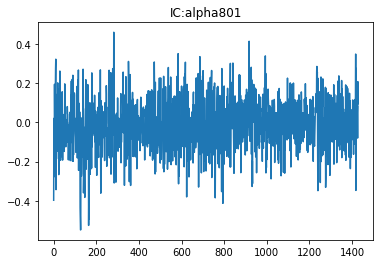

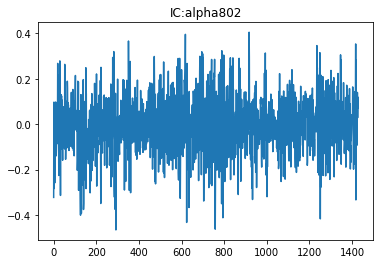

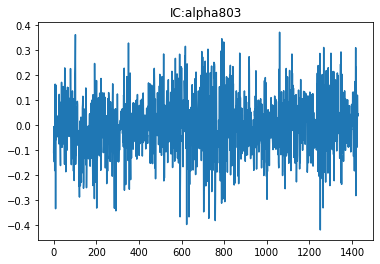

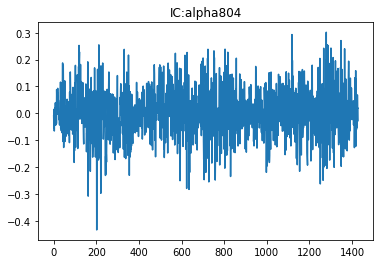

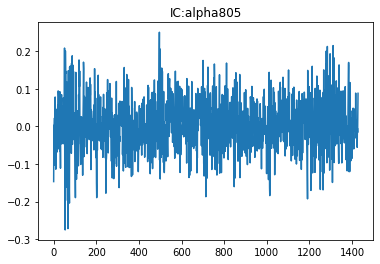

In [77]:
for factor in feature_lst:
    plt.plot(IC.loc[:, [factor]])
    plt.title('IC:%s' %factor)
    plt.show()

In [78]:
# 计算IC均值
ic_mean = IC.iloc[:, 1:].mean()
ic_mean_df = pd.DataFrame(ic_mean, columns=['IC'])

In [79]:
ic_mean_df

,IC
alpha801,-0.010907
alpha802,-0.003462
alpha803,-0.001036
alpha804,0.002865
alpha805,0.005469


## IC值大于0比例

In [80]:
IC_over_ratio = over_ratio(IC.iloc[:, 1:], 0)
IC_over_ratio

alpha801    0.474458
alpha802    0.495451
alpha803    0.498251
alpha804    0.516445
alpha805    0.537439
dtype: float64

## ABS(IC)值大于0.02比例

In [81]:
IC_over2_ratio = over_ratio(abs(IC.iloc[:, 1:]), 0.02)
IC_over2_ratio

alpha801    0.894332
alpha802    0.879636
alpha803    0.855843
alpha804    0.812456
alpha805    0.758572
dtype: float64

In [82]:
IC

,date_time,alpha801,alpha802,alpha803,alpha804,alpha805
0,2015-01-05,-0.396905,-0.322435,-0.109930,-0.009274,-0.146897
1,2015-01-06,0.019716,0.096809,-0.006669,-0.053531,0.002593
2,2015-01-07,-0.237480,-0.283468,-0.097322,0.015237,-0.103290
3,2015-01-08,-0.201787,-0.163161,-0.147713,-0.065915,0.001172
4,2015-01-09,0.193263,-0.041840,-0.004269,-0.008013,0.022038
...,...,...,...,...,...,...
1424,2020-11-10,0.030583,-0.057084,-0.088492,-0.051133,-0.055827
1425,2020-11-11,0.083263,0.139769,0.119701,0.068520,-0.004721
1426,2020-11-12,-0.080328,0.028005,0.037632,0.017574,-0.016548
1427,2020-11-13,0.206911,0.119372,0.045682,0.020097,0.028460


In [83]:
IR_df = pd.DataFrame(IR, columns=['IR'])
IR_df

,IR
alpha801,-0.082288
alpha802,-0.026272
alpha803,-0.008683
alpha804,0.030786
alpha805,0.078487


In [84]:
# # 计算 IC ，IR值,计算rankIC值大于某一阈值的比率
rankIC = rankIC_cal(indicator_df, feature_lst)
rankIR = IR_cal(rankIC)
rankic_mean = rankIC.iloc[:, 1:].mean()
rankic_mean_df = pd.DataFrame(rankic_mean, columns=['rankIC'])
rankic_mean_df

,rankIC
alpha801,-0.011140
alpha802,-0.003496
alpha803,-0.001191
alpha804,0.003109
alpha805,0.006155


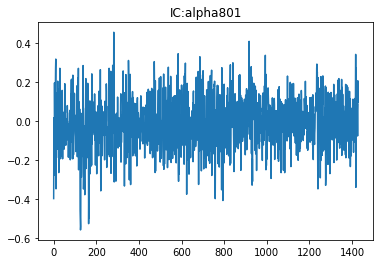

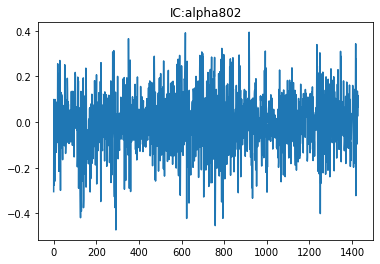

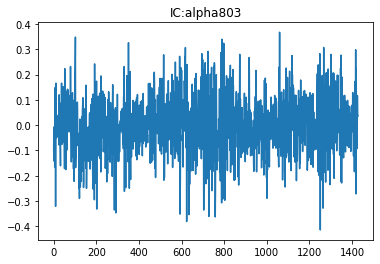

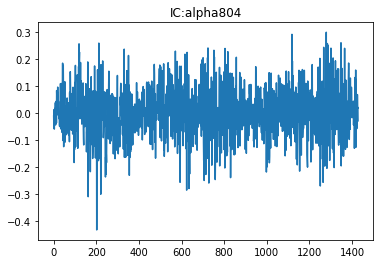

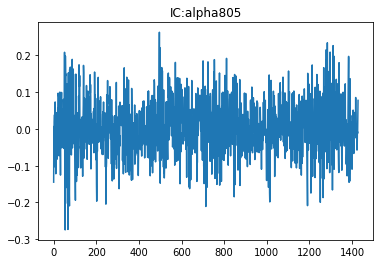

In [85]:
for factor in feature_lst:
    plt.plot(rankIC.loc[:, [factor]])
    plt.title('IC:%s' %factor)
    plt.show()

In [86]:
rankIR

alpha801   -0.083970
alpha802   -0.026855
alpha803   -0.010227
alpha804    0.033301
alpha805    0.082264
dtype: float64

## 单因子回归模型

In [87]:
import statsmodels.api as sm
#模型训练
'''
调用模型的fit方法，对模型进行训练
这个训练过程就是参数求解的过程
并对模型进行拟合
'''
# #查看截距
# alpha = lrModel.intercept_[0]

def get_factor_return(x, y):
    x = sm.add_constant(x)
    model = sm.OLS(y, x, hasconst=True).fit()
#     print(model.summary())
    beta = model.params[1]
    tvalue = model.tvalues[1]
#     print('=========%s' % tvalue)
    return beta, tvalue

# 计算回归因子收益值
def f_cal(df, feature_lst):
    num = 0
    for i in feature_lst:
#         print(i)
        t = df.loc[:, ['date_time', 'future_ret', i]].dropna()
        tmp = t.groupby('date_time').apply(lambda df: get_factor_return(df.iloc[:, 2], df.iloc[:, 1])[0]) \
            .reset_index().rename(columns={0: i})
        if num == 0:
            ret = tmp
        else:
            ret = pd.merge(ret, tmp, on=['date_time'], how='outer')
        num += 1
    return ret


# 计算回归因子收益F的t值检验
def t_cal(df, feature_lst):
    num = 0
    for i in feature_lst:
#         print(i)
        t = df.loc[:, ['date_time', 'future_ret', i]].dropna()
        tmp = t.groupby('date_time').apply(lambda df: get_factor_return(df.iloc[:, 2], df.iloc[:, 1])[1]) \
            .reset_index().rename(columns={0: i})
        if num == 0:
            ret = tmp
        else:
            ret = pd.merge(ret, tmp, on=['date_time'], how='outer')
        num += 1
    return ret

In [88]:
F = f_cal(indicator_df, feature_lst)
F

,date_time,alpha801,alpha802,alpha803,alpha804,alpha805
0,2015-01-05,-0.033689,-0.026978,-0.011274,-0.001006,-0.014601
1,2015-01-06,0.001366,0.006010,-0.000493,-0.004166,0.000187
2,2015-01-07,-0.020523,-0.020903,-0.008317,0.001376,-0.008613
3,2015-01-08,-0.012882,-0.009012,-0.009303,-0.004492,0.000073
4,2015-01-09,0.018955,-0.003684,-0.000424,-0.000874,0.002205
...,...,...,...,...,...,...
1424,2020-11-10,0.002295,-0.003725,-0.005971,-0.003596,-0.004691
1425,2020-11-11,0.004929,0.007402,0.006582,0.003943,-0.000324
1426,2020-11-12,-0.004895,0.001572,0.002190,0.001073,-0.001201
1427,2020-11-13,0.014381,0.007782,0.003094,0.001428,0.002399


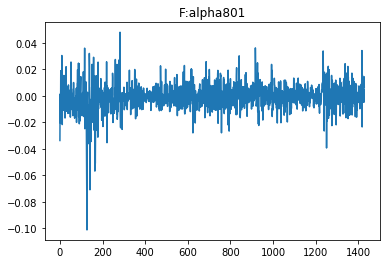

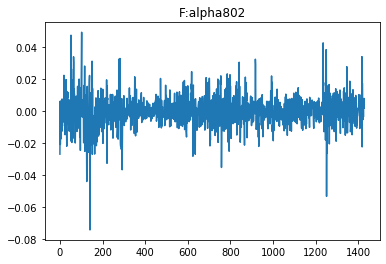

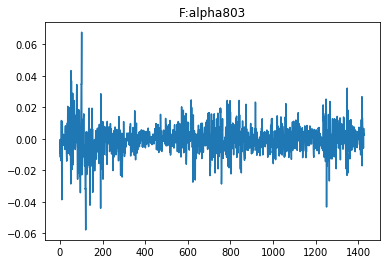

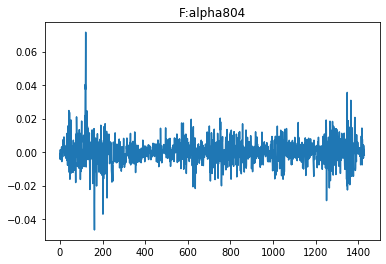

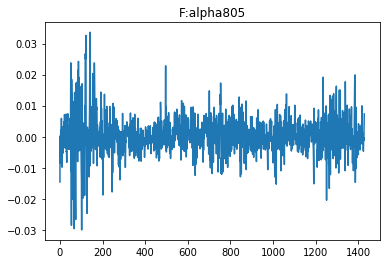

In [89]:
for factor in feature_lst:
    plt.plot(F.loc[:, [factor]])
    plt.title('F:%s' %factor)
    plt.show()

## 因子收益均值

In [90]:
F_mean = F.iloc[:, 1:].mean()
F_mean_df = pd.DataFrame(F_mean, columns=['F'])
F_mean_df

,F
alpha801,-0.000767
alpha802,-0.000203
alpha803,-0.000154
alpha804,0.000198
alpha805,0.000439


In [91]:
T_value = t_cal(indicator_df, feature_lst)
T_value

,date_time,alpha801,alpha802,alpha803,alpha804,alpha805
0,2015-01-05,-11.818712,-9.309774,-3.022854,-0.253483,-4.058931
1,2015-01-06,0.540055,2.663746,-0.182651,-1.468104,0.071012
2,2015-01-07,-6.699664,-8.100539,-2.679770,0.417602,-2.845826
3,2015-01-08,-5.649734,-4.535085,-4.095598,-1.811497,0.032153
4,2015-01-09,5.398012,-1.147603,-0.116990,-0.219597,0.604087
...,...,...,...,...,...,...
1424,2020-11-10,0.864341,-1.615182,-2.509645,-1.446330,-1.579526
1425,2020-11-11,2.360294,3.987462,3.405915,1.940167,-0.133367
1426,2020-11-12,-2.275099,0.790917,1.063148,0.496214,-0.467220
1427,2020-11-13,5.966814,3.392161,1.290185,0.567130,0.803291


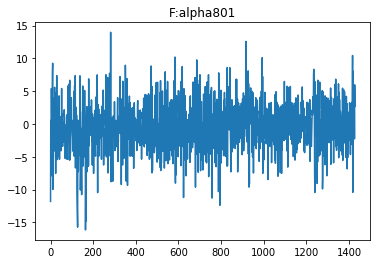

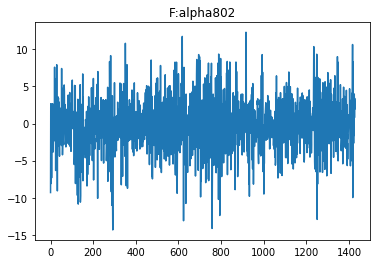

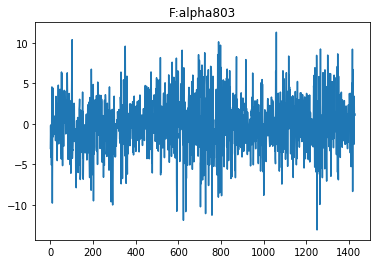

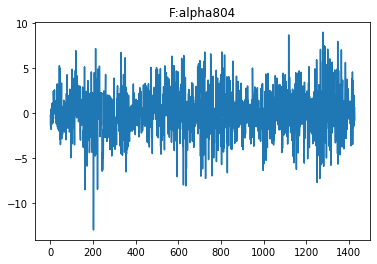

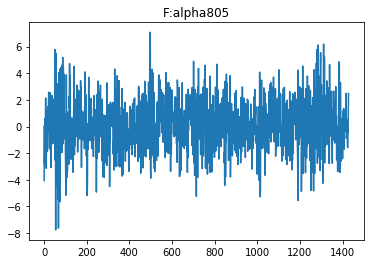

In [92]:
for factor in feature_lst:
    plt.plot(T_value.loc[:, [factor]])
    plt.title('F:%s' %factor)
    plt.show()

## T-value均值

In [93]:
Tvalue_mean = T_value.iloc[:, 1:].mean()
Tvalue_mean_df = pd.DataFrame(Tvalue_mean, columns=['Tvalue'])
Tvalue_mean_df

,Tvalue
alpha801,-0.303597
alpha802,-0.093818
alpha803,-0.023576
alpha804,0.080047
alpha805,0.152212


## T-value绝对值均值

In [94]:
Tvalue_abs_mean = abs(T_value.iloc[:, 1:]).mean()
Tvalue_abs_mean_df = pd.DataFrame(Tvalue_abs_mean, columns=['Tvalue'])
Tvalue_abs_mean_df

,Tvalue
alpha801,2.921321
alpha802,2.913189
alpha803,2.615117
alpha804,2.026385
alpha805,1.515741


In [95]:
T_value

,date_time,alpha801,alpha802,alpha803,alpha804,alpha805
0,2015-01-05,-11.818712,-9.309774,-3.022854,-0.253483,-4.058931
1,2015-01-06,0.540055,2.663746,-0.182651,-1.468104,0.071012
2,2015-01-07,-6.699664,-8.100539,-2.679770,0.417602,-2.845826
3,2015-01-08,-5.649734,-4.535085,-4.095598,-1.811497,0.032153
4,2015-01-09,5.398012,-1.147603,-0.116990,-0.219597,0.604087
...,...,...,...,...,...,...
1424,2020-11-10,0.864341,-1.615182,-2.509645,-1.446330,-1.579526
1425,2020-11-11,2.360294,3.987462,3.405915,1.940167,-0.133367
1426,2020-11-12,-2.275099,0.790917,1.063148,0.496214,-0.467220
1427,2020-11-13,5.966814,3.392161,1.290185,0.567130,0.803291


## T-value>0比率

In [96]:
t_value_over_ratio = over_ratio(T_value.iloc[:, 1:], 0)
t_value_over_ratio

alpha801    0.474458
alpha802    0.495451
alpha803    0.498251
alpha804    0.516445
alpha805    0.537439
dtype: float64

## abs(T-value)>0.02比率

In [97]:
t_abs_value_over_ratio = over_ratio(abs(T_value.iloc[:, 1:]), 0.02)
t_abs_value_over_ratio

alpha801    0.997201
alpha802    0.993702
alpha803    0.997201
alpha804    0.992302
alpha805    0.990203
dtype: float64

## 因子分组组合收益率

In [106]:
def transfer_y_to_feature(ret_lst):
    temp0 = np.percentile(ret_lst,100/10)
    temp1 = np.percentile(ret_lst,200/10)
    temp2 = np.percentile(ret_lst,300/10)
    temp3 = np.percentile(ret_lst,400/10)
    temp4 = np.percentile(ret_lst,500/10)
    temp5 = np.percentile(ret_lst,600/10)
    temp6 = np.percentile(ret_lst,700/10)
    temp7 = np.percentile(ret_lst,800/10)
    temp8 = np.percentile(ret_lst,900/10)
#     print(temp0,temp1)
    y_lst = []
    for y in ret_lst:
        if y > temp8:
            y_lst.append(1)
        elif y > temp7:
            y_lst.append(2)
        elif y > temp6:
            y_lst.append(3)
        elif y > temp5:
            y_lst.append(4)
        elif y > temp4:
            y_lst.append(5)
        elif y > temp3:
            y_lst.append(6)
        elif y > temp2:
            y_lst.append(7)
        elif y > temp1:
            y_lst.append(8)
        elif y > temp0:
            y_lst.append(9)
        else:
            y_lst.append(10)
    return y_lst

In [110]:
lst = []
ls_lst = []
for date, group in indicator_df.groupby(['date_time']):
#     print(date)
    for feature in feature_lst:
        temp = group.loc[:, [feature, 'future_ret']]
        y_feature_lst = transfer_y_to_feature(temp[feature])
        temp['y'] = y_feature_lst
        print(len(temp))
        ret = temp.loc[:, ['y', 'future_ret']].groupby(['y']).mean()['future_ret'].tolist()
#         print(ret)
        row = [date, feature]
        row.extend(ret)
        lst.append(row)
        ls_row = [date, feature]
        ls_row.append(ret[0] - ret[-1])
        ls_lst.append(ls_row)
ret_group = pd.DataFrame(lst, columns=['date_time', 'factor', 'group1', 'group2', 'group3', 'group4', 'group5', 
                                       'group6', 'group7', 'group8', 'group9', 'group10'])
ret_group = ret_group.dropna()
ret_ls = pd.DataFrame(ls_lst, columns=['date_time', 'factor', 'ret_hedge'])
ret_ls = ret_ls.dropna()
ret_group,ret_ls

749
749
749
749
749
752
752
752
752
752
753
753
753
753
753
754
754
754
754
754
753
753
753
753
753
751
751
751
751
751
752
752
752
752
752
753
753
753
753
753
751
751
751
751
751
753
753
753
753
753
749
749
749
749
749
750
750
750
750
750
749
749
749
749
749
749
749
749
749
749
748
748
748
748
748
749
749
749
749
749
750
750
750
750
750
749
749
749
749
749
753
753
753
753
753
751
751
751
751
751
752
752
752
752
752
749
749
749
749
749
749
749
749
749
749
747
747
747
747
747
748
748
748
748
748
750
750
750
750
750
750
750
750
750
750
751
751
751
751
751
750
750
750
750
750
750
750
750
750
750
749
749
749
749
749
756
756
756
756
756
758
758
758
758
758
759
759
759
759
759
759
759
759
759
759
757
757
757
757
757
757
757
757
757
757
756
756
756
756
756
752
752
752
752
752
753
753
753
753
753
748
748
748
748
748
753
753
753
753
753
753
753
753
753
753
751
751
751
751
751
749
749
749
749
749
746
746
746
746
746
747
747
747
747
747
750
750
750
750
750
747
747
747
747
747
746
746
746
746
746


764
764
764
764
764
765
765
765
765
765
762
762
762
762
762
761
761
761
761
761
759
759
759
759
759
756
756
756
756
756
757
757
757
757
757
756
756
756
756
756
755
755
755
755
755
753
753
753
753
753
754
754
754
754
754
752
752
752
752
752
754
754
754
754
754
754
754
754
754
754
756
756
756
756
756
756
756
756
756
756
761
761
761
761
761
764
764
764
764
764
764
764
764
764
764
765
765
765
765
765
766
766
766
766
766
768
768
768
768
768
767
767
767
767
767
766
766
766
766
766
766
766
766
766
766
767
767
767
767
767
768
768
768
768
768
769
769
769
769
769
769
769
769
769
769
769
769
769
769
769
766
766
766
766
766
764
764
764
764
764
764
764
764
764
764
767
767
767
767
767
767
767
767
767
767
767
767
767
767
767
766
766
766
766
766
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
763
761
761
761
761
761
761
761
761
761
761
756
756
756
756
756
755
755
755
755
755
757
757
757
757
757
759
759
759
759
759
760
760
760
760
760
761
761
761
761
761
761
761
761
761
761


759
759
759
759
759
759
759
759
759
759
759
757
757
757
757
757
753
753
753
753
753
751
751
751
751
751
751
751
751
751
751
750
750
750
750
750
750
750
750
750
750
746
746
746
746
746
748
748
748
748
748
748
748
748
748
748
744
744
744
744
744
744
744
744
744
744
745
745
745
745
745
745
745
745
745
745
742
742
742
742
742
736
736
736
736
736
739
739
739
739
739
739
739
739
739
739
739
739
739
739
739
740
740
740
740
740
742
742
742
742
742
743
743
743
743
743
744
744
744
744
744
744
744
744
744
744
747
747
747
747
747
748
748
748
748
748
748
748
748
748
748
748
748
748
748
748
748
748
748
748
748
749
749
749
749
749
750
750
750
750
750
750
750
750
750
750
750
750
750
750
750
750
750
750
750
750
751
751
751
751
751
751
751
751
751
751
751
751
751
751
751
751
751
751
751
751
752
752
752
752
752
752
752
752
752
752
752
752
752
752
752
753
753
753
753
753
753
753
753
753
753
753
753
753
753
753
753
753
753
753
753
757
757
757
757
757
758
758
758
758
758
758
758
758
758
758
758
758
758
758


796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
796
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
798
798
798
798
798
797
797
797
797
797
796
796
796
796
796
796
796
796
796
796
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
798
798
798
798
798
798
798
798
798
798
797
797
797
797
797
797
797
797
797
797
797
797
797
797
797
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
798
799
799
799
799
799
798
798
798
798
798
799
799
799
799
799
799
799
799
799
799
799
799
799
799
799
798
798
798
798
798
798
798
798
798
798
797
797
797
797
797
798
798
798
798
798
798
798
798
798
798
799
799
799
799
799
799
799
799
799
799
799
799
799
799
799
798
798
798
798
798


(       date_time    factor    group1    group2    group3    group4    group5  \
 0     2015-01-05  alpha801 -0.005578 -0.004609  0.003656  0.000924  0.004798   
 1     2015-01-05  alpha802  0.005033  0.006477 -0.002649 -0.003979  0.000311   
 2     2015-01-05  alpha803  0.019619  0.014613  0.012564  0.001167  0.004185   
 5     2015-01-06  alpha801 -0.000118  0.000174 -0.000472 -0.004846  0.003713   
 6     2015-01-06  alpha802  0.005565 -0.002010  0.003380  0.001786  0.003610   
 ...          ...       ...       ...       ...       ...       ...       ...   
 7140  2020-11-16  alpha801 -0.001361  0.001324 -0.000047 -0.002979 -0.003308   
 7141  2020-11-16  alpha802 -0.003143  0.001033 -0.002774 -0.000135 -0.004048   
 7142  2020-11-16  alpha803  0.001951 -0.002793 -0.008029 -0.002109 -0.002241   
 7143  2020-11-16  alpha804 -0.007087 -0.001299 -0.004441 -0.003659 -0.002169   
 7144  2020-11-16  alpha805  0.001898  0.006322 -0.001182 -0.004054 -0.007850   
 
         group6    group7 

       date_time    factor    group1    group2    group3    group4    group5  \
0     2015-01-05  alpha801 -0.005578 -0.004609  0.003656  0.000924  0.004798   
5     2015-01-06  alpha801 -0.000118  0.000174 -0.000472 -0.004846  0.003713   
10    2015-01-07  alpha801 -0.013626 -0.012566 -0.020840 -0.013994 -0.016424   
15    2015-01-08  alpha801 -0.010585 -0.012020 -0.016133 -0.010499 -0.008623   
20    2015-01-09  alpha801 -0.002598  0.004721 -0.008812 -0.017667 -0.019264   
...          ...       ...       ...       ...       ...       ...       ...   
7120  2020-11-10  alpha801 -0.008114 -0.006460 -0.000944 -0.013981 -0.012049   
7125  2020-11-11  alpha801  0.004427  0.009476  0.001582 -0.004065  0.002082   
7130  2020-11-12  alpha801 -0.005490 -0.002387 -0.008189 -0.008113 -0.003258   
7135  2020-11-13  alpha801  0.023369  0.018925  0.019553  0.017690  0.011555   
7140  2020-11-16  alpha801 -0.001361  0.001324 -0.000047 -0.002979 -0.003308   

        group6    group7    group8    g

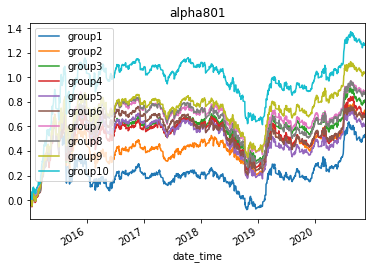

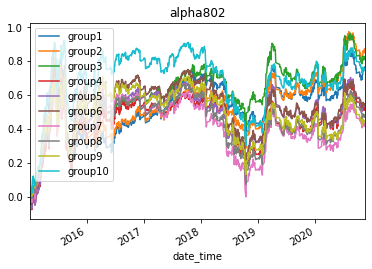

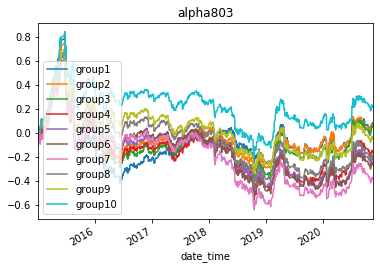

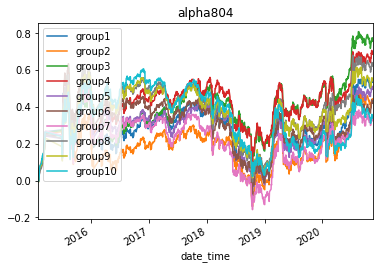

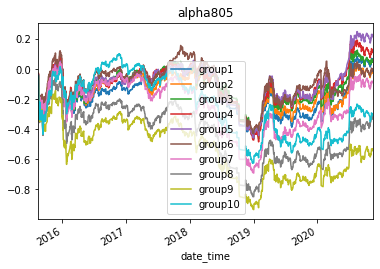

In [108]:
for feature, group in ret_group.groupby(['factor']):
    print(len(group)
    group = group.drop(['factor'], axis=1).set_index(['date_time']).cumsum()
#     print(group)
    group.index = pd.to_datetime(group.index)
    group.plot(legend=0)
    plt.legend()
    plt.title('%s' %(feature))   

## 因子多空收益率

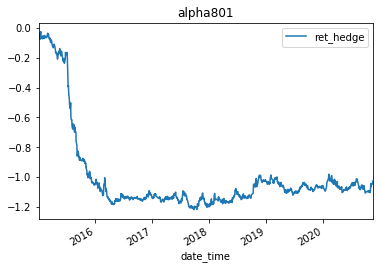

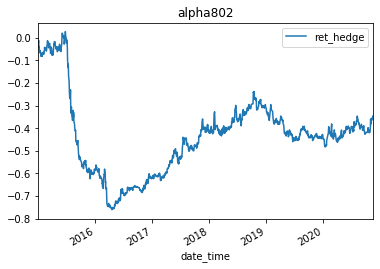

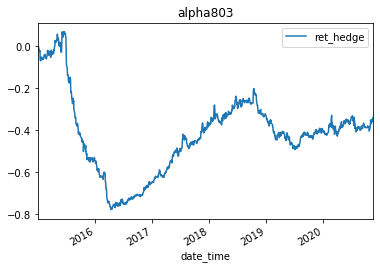

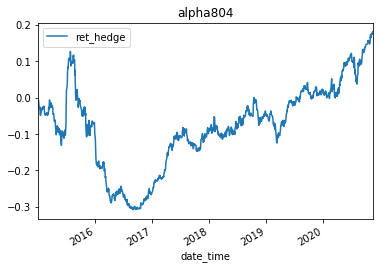

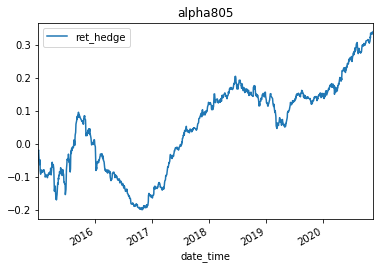

In [109]:
for feature, group in ret_ls.groupby(['factor']):
#     print(group)
    group = group.drop(['factor'], axis=1).set_index(['date_time']).cumsum()
#     print(group)
    group.index = pd.to_datetime(group.index)
    group.plot(legend=0)
    plt.legend()
    plt.title('%s' %(feature))  